# Testing Theano

**Theano** is built around tensors that can be seen as generalizations of scalars, vectors, matrices and so on. A scalar can be defined as a rank-0 tensor, a vector as a rank-1 tensor, etc.

Now we will compute a net input $z$ of a sample point $x$ in a one dimensional dataset with weight $w_1$ and bias $w_0$:

$$
z = x_1 \times w_1 + w_0
$$

In [1]:
import theano
from theano import tensor as T

# initialize symbols
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = x1 * w1 + w0

# compile code
net_input = theano.function(inputs=[w1,x1,w0], outputs=z1)

# run the code
print("Net input: %.2f" % net_input(2.0, 1.0, 0.5))

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Net input: 2.50


Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


Writing code in Theano follows three simple steps:

- Define the *symbols* (Variable objects)
- Compile the code
- And execute

Anyway we have to remember to configure Theano correctly and switch back and forth between *float64* to work with CPU and *float32* to work with GPU.

In [2]:
print(theano.config.floatX)

float32


## Working with array structures

We will create a 2x3 matrix and calculate the column sums

In [3]:
import numpy as np

x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

calc_sum = theano.function(inputs=[x], outputs=x_sum)

ary = [[1,2,3],[1,2,3]]
print("Columns sum: ", calc_sum(ary))

Columns sum:  [ 2.  4.  6.]


In [4]:
ary = np.array([[1,2,3],[1,2,3]], dtype=theano.config.floatX)
print("Columns sum: ", calc_sum(ary))

Columns sum:  [ 2.  4.  6.]


Theano has a smart memory management system that reuses memory, in practice it spreads memory space across multiple devices. We take a look at the *shared* variable which allows us to share large objects and grants multiple functions read and write access, so we can modify those objects after compilation.

In [5]:
# initialize
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[x], updates=update, outputs=z)

# execute
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d:' % i, net_input(data))

z0: [[ 0.]]
z1: [[ 6.]]
z2: [[ 12.]]
z3: [[ 18.]]
z4: [[ 24.]]


We defined an update variable where we declared that we want to update an array w by a value 1.0 after each iteration in the for loop. 

Another trick is to use the *givens* variable to insert values into the graph before compiling it. In this way we can reduce the number of transfers from RAM to CPU and GPU. By using the *inputs* parameter in *theano.function* data is moved between CPU and GPU multiple times. By using *givens* we can keep data on the GPU if it fits in memory.

In [6]:
# initialize
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# compile
net_input = theano.function(inputs=[], updates=update, givens={x: data}, outputs=z)

# execute
for i in range(5):
    print('z%d:', net_input())

z%d: [[ 0.]]
z%d: [[ 6.]]
z%d: [[ 12.]]
z%d: [[ 18.]]
z%d: [[ 24.]]


## Linear regression example

Let's implement **OLS (Ordinary Least Squares)** in Theano. We start by defining a toy dataset.

In [7]:
x_train = np.asarray([[0.0], [1.0],
                      [2.0], [3.0],
                      [4.0], [5.0],
                      [6.0], [7.0],
                      [8.0], [9.0]], dtype=theano.config.floatX)
y_train = np.asarray([1.0, 1.3, 3.1, 2.0,
                      5.0, 6.3, 6.6, 7.4,
                      8.0, 9.0], dtype=theano.config.floatX)

Now we have to implement a training function to learn the weights of the linear regression model. Note that $w_0$ is the bias unit (in this case the intercept at x=0).

In [12]:
def train_linreg(x_train, y_train, eta, epochs):
    costs = []
    eta0 = T.fscalar('eta0')
    y = T.fvector(name='y')
    x = T.fmatrix(name='x')
    w = theano.shared(np.zeros(shape=(x_train.shape[1] + 1), 
                               dtype=theano.config.floatX),
                     name='w')
    
    # calculate cost
    net_input = T.dot(x, w[1:]) + w[0]
    errors = y - net_input
    cost = T.sum(T.pow(errors, 2))
    
    # gradient update
    gradient = T.grad(cost, wrt=w)
    update = [(w, w - eta0 * gradient)]
    
    # compile model
    train = theano.function(inputs=[eta0],
                            outputs=cost,
                            updates=update,
                            givens={x: x_train, 
                                    y: y_train})
    for _ in range(epochs):
        costs.append(train(eta))
    
    return costs, w

A nice Theano feature is the **grad** function that computes the derivative of an expression with respect to its parameters as the *wrt* argument.

In [13]:
import matplotlib.pyplot as plt

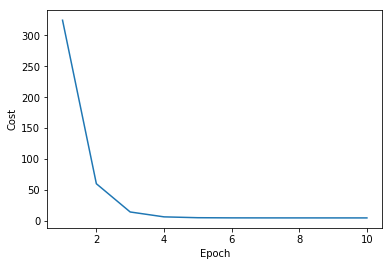

In [14]:
costs, w = train_linreg(x_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs)+1), costs)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()